<a href="https://colab.research.google.com/github/arjasc5231/cs470-team21/blob/main/IOU_AUPRC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import csv
import numpy as np
import pandas as pd

rationale_csv = pd.read_csv("/content/drive/MyDrive/CS470_team_2in1/dataset/preprocessed_balanced_encoded.csv")

In [ ]:
positive_rationale = np.array(rationale_csv["positive rationale encoded"])
negative_rationale = np.array(rationale_csv["negative rationale encoded"])

In [ ]:
print(positive_rationale[43])
print(negative_rationale[43])

[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
# change string to list with value 0 or 1
for i in range(len(positive_rationale)):
    positive_rationale[i] = np.array(positive_rationale[i].replace(" ", "").replace('[', "").replace(']', "").split(','))
    negative_rationale[i] = np.array(negative_rationale[i].replace(" ", "").replace('[', "").replace(']', "").split(','))
    if len(positive_rationale[i]) != len(negative_rationale[i]):
        print(i)

In [ ]:
def IOU(human_rationale, model_rationale): 
    '''
    Calculate Intersection over Union

    Parameters
    -------------------------------------------
    human_rationale: numpy array
        contains true rationale (human checks)
    model_rationale: numpy array
        contains predicted rationale (model checks)

    Returns
    -------------------------------------------
    accuracy: float
        IOU percentage
    '''
    intersec, union = 0, 0
    for i in range(len(human_rationale)):
        human = np.array(human_rationale[i]).astype(np.int32)
        model = np.array(model_rationale[i]).astype(np.int32)

        # print(f"[{i}] human: {human.shape}, model: {model.shape}")

        assert human.shape == model.shape

        for j in range(len(human)):
            intersec += human[j] & model[j] 
            union += human[j] | model[j]

    return intersec / union

In [ ]:
# IOU Example
h = np.array([[0,1,1,1], [0,1,1], [0,0,0], [1,0,0,0,1]])
m = np.array([[0,0,1,0], [1,1,1], [0,1,0], [1,1,0,0,1]])
print(IOU(h,m))
print(IOU(positive_rationale, negative_rationale))

0.5
0.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def set_rationale(relevance_score, threshold):

    rationales = []
    for score in relevance_score:
        # normalize to 0~1
        score = (score - score.min()) / (score.max() - score.min())
        
        rationale = np.where(score > threshold, 1, 0)
        rationales.append(rationale)

    return rationales

In [ ]:
# from nltk.corpus import words
def erase_trivial_words(records):
    tokens = ['[CLS]', '[SEP]', '[MASK]', '[UNK]', '[PAD]']
    trivial = ['.', ',', 'a', 'an', 'the', 'is', 'are', 'they', 'this', 'I', ':', 'he', 'she', 'and', 
               'it', 'we', 'his', '(', ')', 'to', 'was', 'were', 'his', 'her', 'as', 'into', 'for', 
               'here', 'by', ';', 'there', 'on', 'in', '"', 'book', 'books', 'children', 'read', 'children', 
               'kids', 'these', 'will', 'one', 'you', '?', 'that', 'them', 'of', "'", 's', 'with', 'have',
               '-', 'be', 'all', 'if', 'at', 'by', 'when', 'reading', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0']

    for record in records:
        for i in range(len(record[0])):
            if record[0][i] in tokens or record[0][i] in trivial:
                record[4][i] = 0
                record[5][i] = 0
    
    return records

In [ ]:
model_records = np.load("/content/drive/MyDrive/CS470_team_2in1/colab/explanation/amazon_book_expl-transformer_attribution-rationale_binaryclassification.npy", allow_pickle=True)
model_records = erase_trivial_words(model_records)
binary_pos_iou, binary_neg_iou = [], []
for i in range(20):
    model_pos_rationale = set_rationale(model_records[:,5], threshold=i/20)
    model_neg_rationale = set_rationale(model_records[:,4], threshold=i/20)

    print(f"[threshold = {i/20}] positive IOU: {IOU(positive_rationale, model_pos_rationale)}, negative IOU: {IOU(negative_rationale, model_neg_rationale)}")
    binary_pos_iou.append(IOU(positive_rationale, model_pos_rationale))
    binary_neg_iou.append(IOU(negative_rationale, model_neg_rationale))

# print(model_pos_rationale.shape, model_neg_rationale.shape)

[threshold = 0.0] positive IOU: 0.07836907598623245, negative IOU: 0.10555555555555556
[threshold = 0.05] positive IOU: 0.12105535437144335, negative IOU: 0.15441176470588236
[threshold = 0.1] positive IOU: 0.13676975945017184, negative IOU: 0.17591499409681227
[threshold = 0.15] positive IOU: 0.14913793103448275, negative IOU: 0.18526315789473685
[threshold = 0.2] positive IOU: 0.16, negative IOU: 0.18724778046811946
[threshold = 0.25] positive IOU: 0.16783216783216784, negative IOU: 0.19038817005545286
[threshold = 0.3] positive IOU: 0.16601815823605706, negative IOU: 0.19012605042016806
[threshold = 0.35] positive IOU: 0.17276720351390923, negative IOU: 0.18430034129692832
[threshold = 0.4] positive IOU: 0.16957210776545167, negative IOU: 0.17380660954712362
[threshold = 0.45] positive IOU: 0.17504332755632582, negative IOU: 0.16356382978723405
[threshold = 0.5] positive IOU: 0.16883116883116883, negative IOU: 0.15329512893982808
[threshold = 0.55] positive IOU: 0.16205533596837945,

In [ ]:
model_records = np.load("/content/drive/MyDrive/CS470_team_2in1/colab/explanation/amazon_book_expl-transformer_attribution-rationale_regression.npy", allow_pickle=True)
model_records = erase_trivial_words(model_records)

regression_pos_iou, regression_neg_iou = [], []

for i in range(20):
    model_pos_rationale = set_rationale(model_records[:,5], threshold=i/20)
    model_neg_rationale = set_rationale(model_records[:,4], threshold=i/20)

    print(f"[threshold = {i/20}] positive IOU: {IOU(positive_rationale, model_pos_rationale)}, negative IOU: {IOU(negative_rationale, model_neg_rationale)}")

    regression_pos_iou.append(IOU(positive_rationale, model_pos_rationale))
    regression_neg_iou.append(IOU(negative_rationale, model_neg_rationale))

[threshold = 0.0] positive IOU: 0.07834833245103229, negative IOU: 0.1051937780121276
[threshold = 0.05] positive IOU: 0.08274440518256773, negative IOU: 0.1801661474558671
[threshold = 0.1] positive IOU: 0.0881010881010881, negative IOU: 0.21205821205821207
[threshold = 0.15] positive IOU: 0.09193480986209779, negative IOU: 0.23070469798657717
[threshold = 0.2] positive IOU: 0.09444171175602557, negative IOU: 0.22678396871945258
[threshold = 0.25] positive IOU: 0.09919724770642202, negative IOU: 0.2335195530726257
[threshold = 0.3] positive IOU: 0.09993337774816789, negative IOU: 0.23193916349809887
[threshold = 0.35] positive IOU: 0.1007137192704203, negative IOU: 0.22465753424657534
[threshold = 0.4] positive IOU: 0.09515096065873742, negative IOU: 0.21961932650073207
[threshold = 0.45] positive IOU: 0.08802456499488229, negative IOU: 0.19937694704049844
[threshold = 0.5] positive IOU: 0.08041958041958042, negative IOU: 0.18566775244299674
[threshold = 0.55] positive IOU: 0.08125819

In [ ]:
model_records = np.load("/content/drive/MyDrive/CS470_team_2in1/colab/explanation/amazon_book_expl-transformer_attribution-rationale_binaryclassification_notrain.npy", allow_pickle=True)
model_records = erase_trivial_words(model_records)

notrained_pos_iou, notrained_neg_iou = [], []

for i in range(20):
    model_pos_rationale = set_rationale(model_records[:,5], threshold=i/20)
    model_neg_rationale = set_rationale(model_records[:,4], threshold=i/20)

    print(f"[threshold = {i/20}] positive IOU: {IOU(positive_rationale, model_pos_rationale)}, negative IOU: {IOU(negative_rationale, model_neg_rationale)}")

    notrained_pos_iou.append(IOU(positive_rationale, model_pos_rationale))
    notrained_neg_iou.append(IOU(negative_rationale, model_neg_rationale))

[threshold = 0.0] positive IOU: 0.07834833245103229, negative IOU: 0.10516605166051661
[threshold = 0.05] positive IOU: 0.0820280296784831, negative IOU: 0.1019775106630477
[threshold = 0.1] positive IOU: 0.07924743443557583, negative IOU: 0.09484536082474226
[threshold = 0.15] positive IOU: 0.07675438596491228, negative IOU: 0.09968051118210862
[threshold = 0.2] positive IOU: 0.075591985428051, negative IOU: 0.0998452012383901
[threshold = 0.25] positive IOU: 0.07180570221752904, negative IOU: 0.09239130434782608
[threshold = 0.3] positive IOU: 0.06372549019607843, negative IOU: 0.08274470232088799
[threshold = 0.35] positive IOU: 0.06267029972752043, negative IOU: 0.07761529808773904
[threshold = 0.4] positive IOU: 0.06042296072507553, negative IOU: 0.07290400972053462
[threshold = 0.45] positive IOU: 0.057660626029654036, negative IOU: 0.0609597924773022
[threshold = 0.5] positive IOU: 0.053003533568904596, negative IOU: 0.056022408963585436
[threshold = 0.55] positive IOU: 0.050561

In [ ]:
model_records = np.load("/content/drive/MyDrive/CS470_team_2in1/colab/explanation/amazon_book_expl-transformer_attribution-rationale_balanced_binaryclassification.npy", allow_pickle=True)
model_records = erase_trivial_words(model_records)

bal_bin_pos_iou, bal_bin_neg_iou = [], []

for i in range(20):
    model_pos_rationale = set_rationale(model_records[:,5], threshold=i/20)
    model_neg_rationale = set_rationale(model_records[:,4], threshold=i/20)

    print(f"[threshold = {i/20}] positive IOU: {IOU(positive_rationale, model_pos_rationale)}, negative IOU: {IOU(negative_rationale, model_neg_rationale)}")

    bal_bin_pos_iou.append(IOU(positive_rationale, model_pos_rationale))
    bal_bin_neg_iou.append(IOU(negative_rationale, model_neg_rationale))

[threshold = 0.0] positive IOU: 0.07836907598623245, negative IOU: 0.10533262935586062
[threshold = 0.05] positive IOU: 0.0650438946528332, negative IOU: 0.12543192812715964
[threshold = 0.1] positive IOU: 0.05793319415448852, negative IOU: 0.12941643509329098
[threshold = 0.15] positive IOU: 0.04719949653870359, negative IOU: 0.1353211009174312
[threshold = 0.2] positive IOU: 0.04126750184229919, negative IOU: 0.13804173354735153
[threshold = 0.25] positive IOU: 0.03488372093023256, negative IOU: 0.13885505481120586
[threshold = 0.3] positive IOU: 0.031078610603290677, negative IOU: 0.1337448559670782
[threshold = 0.35] positive IOU: 0.021463414634146343, negative IOU: 0.13564668769716087
[threshold = 0.4] positive IOU: 0.01981230448383733, negative IOU: 0.13192612137203166
[threshold = 0.45] positive IOU: 0.020224719101123594, negative IOU: 0.11897738446411013
[threshold = 0.5] positive IOU: 0.01775147928994083, negative IOU: 0.10741138560687433
[threshold = 0.55] positive IOU: 0.017

In [ ]:
model_records = np.load("/content/drive/MyDrive/CS470_team_2in1/colab/explanation/amazon_book_expl-transformer_attribution-rationale_balanced_regression.npy", allow_pickle=True)
model_records = erase_trivial_words(model_records)

bal_reg_pos_iou, bal_reg_neg_iou = [], []

for i in range(20):
    model_pos_rationale = set_rationale(model_records[:,5], threshold=i/20)
    model_neg_rationale = set_rationale(model_records[:,4], threshold=i/20)

    print(f"[threshold = {i/20}] positive IOU: {IOU(positive_rationale, model_pos_rationale)}, negative IOU: {IOU(negative_rationale, model_neg_rationale)}")

    bal_reg_pos_iou.append(IOU(positive_rationale, model_pos_rationale))
    bal_reg_neg_iou.append(IOU(negative_rationale, model_neg_rationale))

[threshold = 0.0] positive IOU: 0.0791113519371444, negative IOU: 0.10547184773988898
[threshold = 0.05] positive IOU: 0.08132045088566828, negative IOU: 0.14007782101167315
[threshold = 0.1] positive IOU: 0.07412653446647781, negative IOU: 0.1525347689546882
[threshold = 0.15] positive IOU: 0.07319757842597689, negative IOU: 0.15955845459106874
[threshold = 0.2] positive IOU: 0.07716436637390213, negative IOU: 0.17086834733893558
[threshold = 0.25] positive IOU: 0.07786589762076424, negative IOU: 0.17926296064959402
[threshold = 0.3] positive IOU: 0.07585644371941272, negative IOU: 0.18554551772063932
[threshold = 0.35] positive IOU: 0.07, negative IOU: 0.19422776911076442
[threshold = 0.4] positive IOU: 0.06339468302658487, negative IOU: 0.202276707530648
[threshold = 0.45] positive IOU: 0.06178489702517163, negative IOU: 0.2034548944337812
[threshold = 0.5] positive IOU: 0.05813953488372093, negative IOU: 0.20042643923240938
[threshold = 0.55] positive IOU: 0.05146036161335188, nega

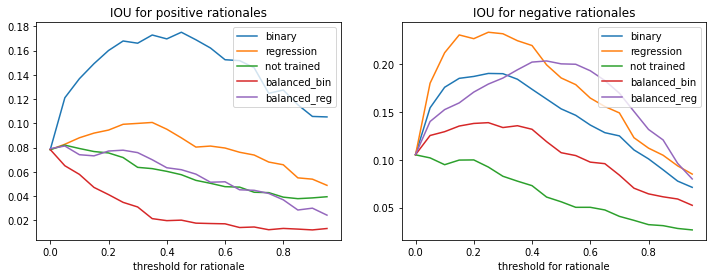

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot([i*0.05 for i in range(len(binary_pos_iou))], binary_pos_iou, label='binary_pos_iou')
plt.plot([i*0.05 for i in range(len(regression_pos_iou))], regression_pos_iou, label='regression_pos_iou')
plt.plot([i*0.05 for i in range(len(notrained_pos_iou))], notrained_pos_iou, label='notrained_pos_iou')
plt.plot([i*0.05 for i in range(len(bal_bin_pos_iou))], bal_bin_pos_iou, label='bal_bin_pos_iou')
plt.plot([i*0.05 for i in range(len(bal_reg_pos_iou))], bal_reg_pos_iou, label='bal_reg_pos_iou')
plt.title('IOU for positive rationales')
plt.xlabel('threshold for rationale')
plt.legend(('binary', 'regression', 'not trained', 'balanced_bin', 'balanced_reg'))
# plt.ylabel('comprehensiveness')

plt.subplot(1, 2, 2)
plt.plot([i*0.05 for i in range(len(binary_neg_iou))], binary_neg_iou, label='binary_neg_iou')
plt.plot([i*0.05 for i in range(len(regression_neg_iou))], regression_neg_iou, label='regression_neg_iou')
plt.plot([i*0.05 for i in range(len(notrained_neg_iou))], notrained_neg_iou, label='notrained_neg_iou')
plt.plot([i*0.05 for i in range(len(bal_bin_neg_iou))], bal_bin_neg_iou, label='bal_bin_neg_iou')
plt.plot([i*0.05 for i in range(len(bal_reg_neg_iou))], bal_reg_neg_iou, label='bal_reg_neg_iou')
plt.title('IOU for negative rationales')
plt.xlabel('threshold for rationale')
# plt.ylabel('sufficiency')
plt.legend(('binary', 'regression', 'not trained', 'balanced_bin', 'balanced_reg'))
plt.savefig(f'iou_regression.png')
plt.show()

In [ ]:
relevance_score = np.array([[0.1, 0.2, 0.3], [0.4, 0.5, 0.6], [0.7, 0.8, 1]])
human_rationale = np.array([[0,0,1], [0,1,1], [0,1,0]])
# print(set_rationale(relevance_score, 0.5))

In [ ]:
import matplotlib.pyplot as plt
def AUPRC(human_rationale, relevance_score, interval): 

    assert human_rationale.shape == relevance_score.shape

    recall, precision = [], []
    thresh_range = [1/interval * i for i in range(interval)]
    for threshold in thresh_range:
        true_positive, false_negative, false_positive = 0, 0, 0
        pred_rationale = set_rationale(relevance_score, threshold) 


        # print(f"{threshold}: {pred_rationale}")
        for i in range(len(human_rationale)):
            for j in range(len(human_rationale[i])):
                if human_rationale[i][j] == 1 and pred_rationale[i][j] == 1:
                    true_positive += 1
                elif human_rationale[i][j] == 1 and pred_rationale[i][j] == 0:
                    false_negative += 1
                elif human_rationale[i][j] == 0 and pred_rationale[i][j] == 1:
                    false_positive += 1
                    
        print(true_positive)
        recall.append(true_positive / (true_positive + false_negative + 1))
        precision.append(true_positive / (false_positive + true_positive + 1))


    # print(recall)
    # print(precision)
    plt.plot(recall, precision)
    plt.show()
    return

0
0
0
0
0
0
0
0
0
0


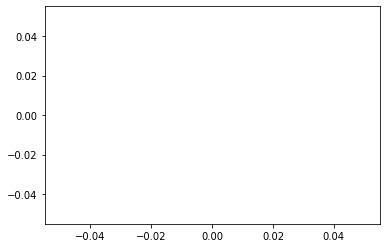

In [ ]:
# model_records = erase_trivial_words(model_records)
model_pos_rationale = np.array(model_records[:,5])
model_neg_rationale = np.array(model_records[:,4])
# model_records = erase_trivial_words(model_records)
# print(model_pos_rationale)

AUPRC(negative_rationale, model_neg_rationale, interval=10)